In [ ]:
!pip install tensorboardX

     |████████████████████████████████| 317kB 21.5MB/s 


In [ ]:
import os
import glob
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F
import torchvision
from torchvision.models.vgg import vgg16
from tensorboardX import SummaryWriter
import numpy as np
import random
import time
import pylab
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class RainDataset(Dataset):
    def __init__(self, opt):
        super(RainDataset, self).__init__()
        self.dataset=opt
        self.img_list = sorted(glob.glob(self.dataset+'/data/*'))
        self.gt_list = sorted(glob.glob(self.dataset+'/gt/*'))
   
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = self.img_list[idx]
        gt_name = self.gt_list[idx]

        img = cv2.imread(img_name,-1)
        gt = cv2.imread(gt_name,-1)

        img = cv2.resize(img, (224,224), interpolation=cv2.INTER_AREA)
        gt = cv2.resize(gt, (224,224), interpolation=cv2.INTER_AREA)
        # img = np.asarray(img).transpose((2,0,1))
        # gt = np.asarray(gt).transpose((2,0,1))

        if img.dtype == np.uint8:
            img = (img / 255.0).astype('float32')
        if gt.dtype == np.uint8:
            gt = (gt / 255.0).astype('float32')

        return [img,gt]

In [ ]:
!gdown --id 1FaQ0U6NPwQr5MKdHaf7419XEaYDJDYdi --output train.zip

Downloading...
From: https://drive.google.com/uc?id=1FaQ0U6NPwQr5MKdHaf7419XEaYDJDYdi
To: /content/train.zip
1.07GB [00:11, 94.9MB/s]


In [ ]:
!unzip train.zip

Archive:  train.zip
   creating: train/
  inflating: train/preview.html      
   creating: __MACOSX/
   creating: __MACOSX/train/
  inflating: __MACOSX/train/._preview.html  
  inflating: train/.DS_Store         
  inflating: __MACOSX/train/._.DS_Store  
   creating: train/gt/
  inflating: train/gt/73_clean.png   
  inflating: train/gt/354_clean.png  
  inflating: train/gt/448_clean.png  
  inflating: train/gt/162_clean.png  
  inflating: train/gt/481_clean.png  
  inflating: train/gt/738_clean.png  
  inflating: train/gt/212_clean.png  
  inflating: train/gt/815_clean.png  
  inflating: train/gt/742_clean.png  
  inflating: train/gt/268_clean.png  
  inflating: train/gt/574_clean.png  
  inflating: train/gt/604_clean.png  
  inflating: train/gt/432_clean.png  
  inflating: train/gt/118_clean.png  
  inflating: train/gt/426_clean.png  
  inflating: train/gt/610_clean.png  
  inflating: train/gt/560_clean.png  
  inflating: train/gt/756_clean.png  
  inflating: train/gt/801_clean.png  


In [ ]:
!gdown --id 1R6WfCEglbwTNDPYOhESAt80Lu5Ecz5dI --output test_a.zip

Downloading...
From: https://drive.google.com/uc?id=1R6WfCEglbwTNDPYOhESAt80Lu5Ecz5dI
To: /content/test_a.zip
63.7MB [00:02, 28.7MB/s]


In [ ]:
!unzip test_a.zip

Archive:  test_a.zip
   creating: test_a/
   creating: test_a/gt/
  inflating: test_a/gt/46_clean.png  
  inflating: test_a/gt/52_clean.png  
  inflating: test_a/gt/28_clean.png  
  inflating: test_a/gt/2_clean.png   
  inflating: test_a/gt/10_clean.png  
  inflating: test_a/gt/31_clean.png  
  inflating: test_a/gt/25_clean.png  
  inflating: test_a/gt/40_clean.png  
  inflating: test_a/gt/4_clean.png   
  inflating: test_a/gt/54_clean.png  
  inflating: test_a/gt/37_clean.png  
  inflating: test_a/gt/9_clean.png   
  inflating: test_a/gt/23_clean.png  
  inflating: test_a/gt/16_clean.png  
  inflating: test_a/gt/53_clean.png  
  inflating: test_a/gt/29_clean.png  
  inflating: test_a/gt/3_clean.png   
  inflating: test_a/gt/47_clean.png  
  inflating: test_a/gt/11_clean.png  
  inflating: test_a/gt/24_clean.png  
  inflating: test_a/gt/30_clean.png  
  inflating: test_a/gt/5_clean.png   
  inflating: test_a/gt/55_clean.png  
  inflating: test_a/gt/41_clean.png  
  inflating: test_a/gt

In [ ]:
train_dataset=RainDataset('train/')
valid_dataset=RainDataset('test_a/')

In [ ]:
batch_size=1
lr=0.0005
iter=200

In [ ]:
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader=DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
len(train_loader),len(valid_loader)

(861, 58)

In [ ]:
img1=train_dataset.__getitem__(10)[0]
gt1=train_dataset.__getitem__(10)[1]

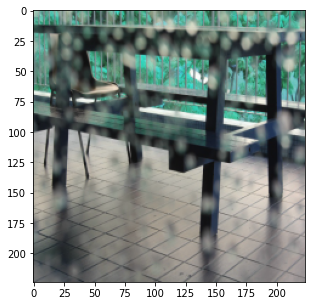

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.imshow(img1)
plt.show()

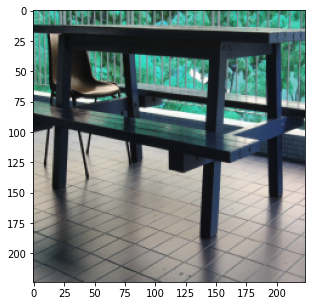

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.imshow(gt1)
plt.show()

In [ ]:
ITERATION = 4

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.det_conv0 = nn.Sequential(
            nn.Conv2d(4, 32, 3, 1, 1),
            nn.ReLU() # LeakyReLU(0.2)
            )
        self.det_conv1 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU()
            )
        self.det_conv2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU()
            )
        self.det_conv3 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU()
            )
        self.det_conv4 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU()
            )
        self.det_conv5 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU()
            )
        self.conv_i = nn.Sequential(
            nn.Conv2d(32 + 32, 32, 3, 1, 1),
            nn.Sigmoid()
            )
        self.conv_f = nn.Sequential(
            nn.Conv2d(32 + 32, 32, 3, 1, 1),
            nn.Sigmoid()
            )
        self.conv_g = nn.Sequential(
            nn.Conv2d(32 + 32, 32, 3, 1, 1),
            nn.Tanh()
            )
        self.conv_o = nn.Sequential(
            nn.Conv2d(32 + 32, 32, 3, 1, 1),
            nn.Sigmoid()
            )
        self.det_conv_mask = nn.Sequential(
            nn.Conv2d(32, 1, 3, 1, 1),
            )
        self.conv1 = nn.Sequential(
            nn.Conv2d(4, 64, 5, 1, 2),
            nn.ReLU()
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.ReLU()
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.ReLU()
            )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.ReLU()
            )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU()
            )
        self.conv6 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU()
            )
        self.diconv1 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 2, dilation = 2),
            nn.ReLU()
            )
        self.diconv2 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 4, dilation = 4),
            nn.ReLU()
            )
        self.diconv3 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 8, dilation = 8),
            nn.ReLU()
            )
        self.diconv4 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 16, dilation = 16),
            nn.ReLU()
            )
        self.conv7 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU()
            )
        self.conv8 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU()
            )
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReflectionPad2d((1, 0, 1, 0)),
            nn.AvgPool2d(2, stride = 1),
            nn.ReLU()
            )
        self.conv9 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.ReLU()
            )
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReflectionPad2d((1, 0, 1, 0)),
            nn.AvgPool2d(2, stride = 1),
            nn.ReLU()
            )
        self.conv10 = nn.Sequential(
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.ReLU()
            )
        self.outframe1 = nn.Sequential(
            nn.Conv2d(256, 3, 3, 1, 1),
            nn.ReLU()
            )
        self.outframe2 = nn.Sequential(
            nn.Conv2d(128, 3, 3, 1, 1),
            nn.ReLU()
            )
        self.output = nn.Sequential(
            nn.Conv2d(32, 3, 3, 1, 1)
            )

    def forward(self, input):
        batch_size, row, col = input.size(0), input.size(2), input.size(3)
        mask = Variable(torch.ones(batch_size, 1, row, col)).to(device) / 2.
        h = Variable(torch.zeros(batch_size, 32, row, col)).to(device) 
        c = Variable(torch.zeros(batch_size, 32, row, col)).to(device)
        mask_list = []
        for i in range(ITERATION):
            x = torch.cat((input, mask), 1)
            x = self.det_conv0(x)
            resx = x
            x = F.relu(self.det_conv1(x) + resx)  ## ResNet Block - > Pre Activation 구조로 변형해보기
            resx = x
            x = F.relu(self.det_conv2(x) + resx)
            resx = x
            x = F.relu(self.det_conv3(x) + resx)
            resx = x
            x = F.relu(self.det_conv4(x) + resx)
            resx = x
            x = F.relu(self.det_conv5(x) + resx)
            x = torch.cat((x, h), 1)
            i = self.conv_i(x)
            f = self.conv_f(x)
            g = self.conv_g(x)
            o = self.conv_o(x)
            c = f * c + i * g
            h = o * torch.tanh(c)
            mask = self.det_conv_mask(h)
            mask_list.append(mask)
        x = torch.cat((input, mask), 1)
        x = self.conv1(x)
        res1 = x
        x = self.conv2(x)
        x = self.conv3(x)
        res2 = x
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.diconv1(x)
        x = self.diconv2(x)
        x = self.diconv3(x)
        x = self.diconv4(x)
        x = self.conv7(x)
        x = self.conv8(x)
        frame1 = self.outframe1(x)
        x = self.deconv1(x)
        x = x + res2
        x = self.conv9(x)
        frame2 = self.outframe2(x)
        x = self.deconv2(x)
        x = x + res1
        x = self.conv10(x)
        x = self.output(x)
        return mask_list, frame1, frame2, x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 8, 5, 1, 2),
            nn.ReLU()
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 5, 1, 2),
            nn.ReLU()
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 64, 5, 1, 2),
            nn.ReLU()
            )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, 5, 1, 2),
            nn.ReLU()
            )
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 128, 5, 1, 2),
            nn.ReLU()
            )
        self.conv6 = nn.Sequential(
            nn.Conv2d(128, 128, 5, 1, 2),
            nn.ReLU()
            )
        self.conv_mask = nn.Sequential(
            nn.Conv2d(128, 1, 5, 1, 2)
            )
        self.conv7 = nn.Sequential(
            nn.Conv2d(128, 64, 5, 4, 1),
            nn.ReLU()
            )
        self.conv8 = nn.Sequential(
            nn.Conv2d(64, 32, 5, 4, 1),
            nn.ReLU()
            )
        self.fc = nn.Sequential(
            nn.Linear(32 * 14 * 14, 1024),
            nn.Linear(1024, 1),
            nn.Sigmoid()
            )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        mask = self.conv_mask(x)
        x = self.conv7(x * mask)
        # x = self.conv7(x)
        # print 7, x.shape
        x = self.conv8(x)
        x=x.reshape(x.size(0), -1)
        return [mask, self.fc(x)]

In [ ]:
def trainable(net, trainable):
    for para in net.parameters():
        para.requires_grad = trainable

#Initialize VGG16 with pretrained weight on ImageNet
def vgg_init():
    vgg_model = vgg16(pretrained = True).to(device)
    trainable(vgg_model, False)
    return vgg_model

class vgg(nn.Module):
    def __init__(self, vgg_model):
        super(vgg, self).__init__()
        self.vgg_layers = vgg_model.features
        self.layer_name_mapping = {
            '1': "relu1_1",
            '3': "relu1_2",
            '6': "relu2_1",
            '8': "relu2_2"
        }

    def forward(self, x):
        output = []
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output.append(x)
        return output

In [ ]:
def torch_variable(x,is_train):
  if is_train:
    return Variable(torch.from_numpy(np.array(x).transpose((0,3,1,2))),requires_grad=True).to(device)
  else:
    with torch.no_grad():
      result=torch.from_numpy(np.array(x).transpose((0,3,1,2))).to(device)
    return result

In [ ]:
def get_heatmap(mask):
	lum_img = np.maximum(np.maximum(mask[:,:,0],mask[:,:,1],),mask[:,:,2])
	imgplot = plt.imshow(lum_img)
	imgplot.set_cmap('jet')
	plt.colorbar()
	plt.axis('off')
	pylab.show()
	return

def get_mask(dg_img,img):
	# downgraded image - image
	mask = np.fabs(dg_img-img)
	# threshold under 30
	mask[np.where(mask<(30.0/255.0))] = 0.0
	mask[np.where(mask>0.0)] = 1.0
	#avg? max?
	# mask = np.average(mask, axis=2)
	mask = np.max(mask, axis=2)
	mask = np.expand_dims(mask, axis=2)
	return mask

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, real_label=1.0, fake_label=0.0):
        super(GANLoss, self).__init__()
        self.real_label = real_label
        self.fake_label = fake_label
        # self.loss = nn.MSELoss().to(device)
        self.loss = nn.BCELoss().to(device)
    def convert_tensor(self, input, is_real):
        if is_real:
            return Variable(torch.FloatTensor(input.size()).fill_(self.real_label)).to(device)
        else:
            return Variable(torch.FloatTensor(input.size()).fill_(self.fake_label)).to(device) 
    def __call__(self, input, is_real):
        return self.loss(input, self.convert_tensor(input,is_real).to(device))

class AttentionLoss(nn.Module):
    def __init__(self, theta=0.8, iteration=4):
        super(AttentionLoss, self).__init__()
        self.theta = theta
        self.iteration = iteration
        self.loss = nn.MSELoss().to(device)

    def __call__(self, A_, M_):
        loss_ATT = None
        for i in range(1, self.iteration+1):
            if i == 1:
                loss_ATT = pow(self.theta, float(self.iteration-i)) * self.loss(A_[i-1],M_)
            else:
                loss_ATT += pow(self.theta, float(self.iteration-i)) * self.loss(A_[i-1],M_)
        return loss_ATT

# VGG16 pretrained on Imagenet
def trainable_(net, trainable):
    for param in net.parameters():
        param.requires_grad = trainable

class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        self.model = (vgg16(pretrained = True).to(device))
        trainable_(self.model, False)

        self.loss = nn.MSELoss().to(device)
        self.vgg_layers = self.model.features
        self.layer_name_mapping = {
            '1': "relu1_1",
            '3': "relu1_2",
            '6': "relu2_1",
            '8': "relu2_2"
        }
    def get_layer_output(self,x):
      with torch.no_grad():
        output = []
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output.append(x)
      return output

    def __call__(self, O_, T_):
        o = self.get_layer_output(O_)
        t = self.get_layer_output(T_)
        loss_PL = None
        for i in range(len(t)):
            if i == 0:
                loss_PL = self.loss(o[i],t[i]) / float(len(t))
            else:
                loss_PL += self.loss(o[i],t[i]) / float(len(t))
        return loss_PL
        
class MultiscaleLoss(nn.Module):
    def __init__(self, ld=[0.6,0.8,1.0],batch=1):
        super(MultiscaleLoss, self).__init__()
        self.loss = nn.MSELoss().to(device)
        self.ld = ld
        self.batch=batch
    def __call__(self, S_, gt):
        #1,128,256,3
        T_ = []
        # print S_[0].shape[0]
        for i in range(S_[0].shape[0]):
            temp = []
            x = (np.array(gt[i])*255.).astype(np.uint8)
            # print (x.shape, x.dtype)
            t = cv2.resize(x, None, fx=1.0/4.0,fy=1.0/4.0, interpolation=cv2.INTER_AREA)
            t = np.expand_dims((t/255.).astype(np.float32).transpose(2,0,1),axis=0)
            temp.append(t)
            t = cv2.resize(x, None, fx=1.0/2.0,fy=1.0/2.0, interpolation=cv2.INTER_AREA)
            t = np.expand_dims((t/255.).astype(np.float32).transpose(2,0,1),axis=0)
            temp.append(t)
            x = np.expand_dims((x/255.).astype(np.float32).transpose(2,0,1),axis=0)
            temp.append(x)
            T_.append(temp)
        temp_T = []
        for i in range(len(self.ld)):
            # if self.batch == 1:
            #     temp_T.append(Variable(torch.from_numpy(T_[0][i])).to(device))
            # else:
            for j in range((S_[0].shape[0])):
                if j == 0:
                    x = T_[j][i]
                else:
                    x = np.concatenate((x, T_[j][i]), axis=0)
            temp_T.append(Variable(torch.from_numpy(x)).to(device))
        T_ = temp_T
        loss_ML = None
        for i in range(len(self.ld)):
            if i == 0: 
                loss_ML = self.ld[i] * self.loss(S_[i], T_[i])
            else:
                loss_ML += self.ld[i] * self.loss(S_[i], T_[i])
        
        return loss_ML/float(S_[0].shape[0])

class MAPLoss(nn.Module):
    def __init__(self, gamma=0.05):
        super(MAPLoss, self).__init__()
        self.loss = nn.MSELoss().to(device)
        self.gamma = gamma

    # D_map_O, D_map_R
    def __call__(self, D_O, D_R, A_N):
        Z = Variable(torch.zeros(D_R.shape)).to(device)
        D_A = self.loss(D_O,A_N)
        D_Z = self.loss(D_R,Z)
        return self.gamma * (D_A + D_Z)

In [ ]:
class trainer:
  def __init__(self, iter=500, batch_size=1):
    self.net_D = Discriminator().to(device)
    self.net_G = Generator().to(device)
    self.optim1=torch.optim.Adam(filter(lambda p : p.requires_grad, self.net_G.parameters()), lr = lr, betas = (0.5,0.99))
    self.optim2=torch.optim.Adam(filter(lambda p : p.requires_grad, self.net_G.parameters()), lr = lr, betas = (0.5,0.99))
    self.iter=iter
    self.batch_size=batch_size
    self.expr_dir='./checkpoints'

    # Attention Loss
    self.criterionAtt = AttentionLoss(theta=0.8, iteration=4)  ## theta랑 iteration 수정해보기
    # GAN Loss
    self.criterionGAN = GANLoss(real_label=1.0, fake_label=0.0)
    # Perceptual Loss
    self.criterionPL = PerceptualLoss()
    # Multiscale Loss
    self.criterionML = MultiscaleLoss(ld = [0.6,0.8,1.0],batch=self.batch_size) ## ld 수정해보기
    # MAP Loss
    self.criterionMAP = MAPLoss()
    # MSE Loss
    self.criterionMSE = nn.MSELoss().to(device)

    self.out_path = './weight/'

  def forward_process(self,I_,GT,is_train=True):
    M_ = []
    for i in range(I_.shape[0]):
      M_.append(get_mask(np.array(I_[i]),np.array(GT[i])))
    M_ = np.array(M_)
    M_ = torch_variable(M_,is_train)
    I_ = torch_variable(I_,is_train)
    GT_= torch_variable(GT, is_train)

    A_,t1,t2,t3 = self.net_G(I_)
    S_ = [t1,t2,t3]
    O_ = t3

    loss = self.criterionMSE(O_,GT_.detach())

    if is_train:
      # Attention Loss
      loss_att=self.criterionAtt(A_,M_.detach())

      # Perceptual Loss O_ : Generation
      loss_PL = self.criterionPL(O_, GT_) # .detach()

      # Multiscale Loss
      loss_ML=self.criterionML(S_,GT) # 왜 여기는 GT_가 아니지?

      D_map_O, D_fake = self.net_D(t3)
      D_map_R, D_real = self.net_D(GT_)

      loss_MAP = self.criterionMAP(D_map_O, D_map_R, A_[-1].detach())

      # 1: D_real , 0: D_fake
      
      loss_fake = self.criterionGAN(D_fake,is_real=False)
      loss_real = self.criterionGAN(D_real,is_real=True)
      loss_D = loss_real + loss_fake + loss_MAP

      loss_G = 0.01*(-loss_fake) + loss_att + loss_ML + loss_PL

      output = [loss_G, loss_D, loss_PL, loss_ML, loss_att, loss_MAP, loss]

    else :
      output = loss

    return output

  def train_start(self):
    loss_sum=0.0
    valid_loss_sum=0.0
    # I_ : input raindrop image
    # A_ : attention map
    # M_ : mask GT
    # O_ : output image of the autoencoder
    # T_ : GT
    writer = SummaryWriter()
    count = 0
    before_loss = 10000000
    for epoch in range(1, self.iter+1):
      tot_loss_G = 0.0
      tot_loss_D = 0.0
      tot_MSE = 0.0
      tot_loss_PL = 0.0
      tot_loss_ML = 0.0
      tot_loss_att = 0.0
      tot_loss_MAP = 0.0

      for i, (I_,GT_) in enumerate(train_loader):
        count+=1
        #I_ = I_.to(device)
        #GT_ = GT_.to(device)
        self.optim1.zero_grad()
        self.optim2.zero_grad()
        loss_G, loss_D, loss_PL, loss_ML, loss_att, loss_MAP, MSE_loss = self.forward_process(I_,GT_)        

        loss_G.backward(retain_graph=True)
        loss_D.backward()

        self.optim1.step()
        self.optim2.step()

        tot_loss_G += loss_G.item()
        tot_loss_D += loss_D.item()
        tot_MSE += MSE_loss.item()
        tot_loss_PL += loss_PL.item()
        tot_loss_ML += loss_ML.item()
        tot_loss_att += loss_att.item()
        tot_loss_MAP += loss_MAP.item()

        if count == 1:
          print('count: '+str(count)+' loss G: {:.4f}'.format(float(tot_loss_G))+' loss_D: {:.4f}'.format(float(tot_loss_D))+' loss_MSE: {:.4f}'.format(float(tot_MSE)))
          print('loss_PL:{:.4f}'.format(float(tot_loss_PL))+' loss_ML:{:.4f}'.format(float(tot_loss_ML))+' loss_Att:{:.4f}'.format(float(tot_loss_att))+' loss_MAP:{:.4f}'.format(float(tot_loss_MAP)))
          writer.add_scalar('loss_G', float(tot_loss_G), count)
          writer.add_scalar('loss_D', float(tot_loss_D), count)

        if count % 20 == 0:
          print('count: '+str(count)+' loss G: {:.4f}'.format(float(tot_loss_G/20))+' loss_D: {:.4f}'.format(float(tot_loss_D/20))+' loss_MSE: {:.4f}'.format(float(tot_MSE/20)))
          print('loss_PL:{:.4f}'.format(float(tot_loss_PL/20))+' loss_ML:{:.4f}'.format(float(tot_loss_ML/20))+' loss_Att:{:.4f}'.format(float(tot_loss_att/20))+' loss_MAP:{:.4f}'.format(float(tot_loss_MAP/20)))
          writer.add_scalar('loss_G', float(tot_loss_G/20), count)
          writer.add_scalar('loss_D', float(tot_loss_D/20), count)
          tot_loss_G = 0.0
          tot_loss_D = 0.0
          tot_MSE = 0.0
          tot_loss_PL = 0.0
          tot_loss_ML = 0.0
          tot_loss_att = 0.0
          tot_loss_MAP = 0.0

      step = 0
      with torch.no_grad():
        for i, (I_val,GT_val) in enumerate(valid_loader):
          #I_val = I_val.to(device)
          #GT_val = GT_val.to(device)
          if i == 0:
            valid_loss_sum = self.forward_process(I_val,GT_val,is_train=False)
          else:
            valid_loss_sum += self.forward_process(I_val,GT_val,is_train=False)
          step+=1
      
        print('epoch : '+str(epoch)+', valid_loss:{} '.format(valid_loss_sum.item()/step)+'\n')
        writer.add_scalar('validation_loss', float(valid_loss_sum.item())/step, epoch)
        valid_loss_sum = float(valid_loss_sum.item())/step

      if before_loss/valid_loss_sum > 1.01:
        before_loss = valid_loss_sum
        print("save model " + "!"*10)
        if not os.path.exists(self.out_path):
          os.system('mkdir -p {}'.format(self.out_path))
        w_name = 'G_epoch:{}_loss:{}.pth'.format(epoch,valid_loss_sum)
        save_path = os.path.join(self.out_path, w_name)
        torch.save(self.net_G.state_dict(), save_path)
      valid_loss_sum=0.0

    writer.export_scalars_to_json("./attention_video_restoration.json")
    writer.close()
    return

In [ ]:
tr = trainer()
tr.train_start()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



count: 1 loss G: 0.8250 loss_D: 1.3863 loss_MSE: 0.1640
loss_PL:0.2517 loss_ML:0.3702 loss_Att:0.2100 loss_MAP:0.0000
count: 20 loss G: 1.4473 loss_D: 1.3892 loss_MSE: 0.0505
loss_PL:0.3520 loss_ML:0.6016 loss_Att:0.5007 loss_MAP:0.0029
count: 40 loss G: 0.9528 loss_D: 1.3886 loss_MSE: 0.0217
loss_PL:0.3803 loss_ML:0.1124 loss_Att:0.4670 loss_MAP:0.0023
count: 60 loss G: 0.8924 loss_D: 1.3886 loss_MSE: 0.0166
loss_PL:0.3800 loss_ML:0.0678 loss_Att:0.4515 loss_MAP:0.0023
count: 80 loss G: 0.8066 loss_D: 1.3881 loss_MSE: 0.0195
loss_PL:0.3365 loss_ML:0.0861 loss_Att:0.3909 loss_MAP:0.0018
count: 100 loss G: 0.8087 loss_D: 1.3880 loss_MSE: 0.0119
loss_PL:0.2874 loss_ML:0.1394 loss_Att:0.3890 loss_MAP:0.0016
count: 120 loss G: 1.0040 loss_D: 1.3892 loss_MSE: 0.0194
loss_PL:0.3549 loss_ML:0.1442 loss_Att:0.5118 loss_MAP:0.0029
count: 140 loss G: 1.1584 loss_D: 1.3894 loss_MSE: 0.0180
loss_PL:0.3027 loss_ML:0.3507 loss_Att:0.5119 loss_MAP:0.0031
count: 160 loss G: 0.9725 loss_D: 1.3887 loss

KeyboardInterrupt: ignored